In [2]:
import numpy as np
import wave
from scipy.io import wavfile
from scipy import signal
from tensorflow.keras.models import Model
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.models import model_from_json
import soundfile as sf
import os
import pyaudio
import time
import math

In [3]:
with open('/media/data/NewSnippets/Weights/TrialThree.json', mode='r') as f:
    model = model_from_json(f.read())

model.load_weights('/media/data/NewSnippets/Weights/TrialThree.h5')

W0827 17:38:28.084772 139620787279680 deprecation.py:506] From /home/josephcleveland/Research/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 17:38:28.086052 139620787279680 deprecation.py:506] From /home/josephcleveland/Research/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 17:38:28.088476 139620787279680 deprecation.py:506] From /home/josephcleveland/Research/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Variance

/home/josephcleveland/Research/venv/lib/python3.6/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


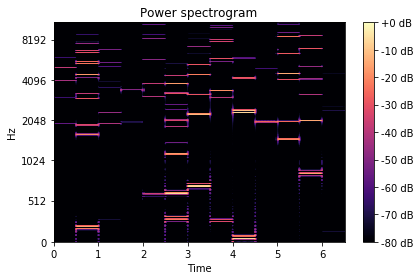

In [4]:
audio,_ = sf.read('/home/josephcleveland/Research/NewTrials/ManySamps.wav')
#audio,_ = sf.read('/media/data/NewSnippets/Samps/samp38.wav')


spect = np.abs(librosa.feature.melspectrogram(audio, sr=44100, n_mels=512))
librosa.display.specshow(librosa.amplitude_to_db(spect,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

spect = spect.T
outs = np.zeros((spect.shape[0], 5))

spect = np.expand_dims(spect, axis=2)
spect = np.expand_dims(spect, axis=3)
outs = model.predict(spect)


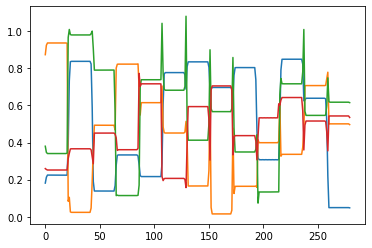

In [5]:
plt.plot(outs[:,0])
plt.plot(outs[:,1])
plt.plot(outs[:,2])
plt.plot(outs[:,3])

In [8]:
p = pyaudio.PyAudio()
t = 0
RATE = 44100
length = outs.shape[0]
audio_buffer = np.zeros(0)

def callback(in_data, frame_count, time_info, status):
    global t, RATE, length, outs, audio_buffer
    

    while len(audio_buffer) <= frame_count * 30:
        index = int( t / RATE * length / 3.25)
        if(index >= length):
            A = 0
            C = 0
            D = 0
            M = 0
        else:
            A = outs[index, 0]
            C = outs[index, 1] * 220 * 16
            D = outs[index, 2] * 5
            M = outs[index, 3] * 220 * 32
        fmout = np.zeros(frame_count)
        for s in range(frame_count):
            fmout[s] = A * math.sin(2 * math.pi / RATE * C * t + 
                       D * math.sin(2 * math.pi / RATE * M * t))
            fmout[s] = fmout[s] * 2000
            t = t + 1
        audio_buffer = np.append(audio_buffer, fmout)
    
    output = audio_buffer[:frame_count]
    audio_buffer = audio_buffer[frame_count:]
    output = output.astype('int16')
    return  (output, pyaudio.paContinue)

stream = p.open(format=pyaudio.paInt16,
               channels=1,
               rate=RATE,
               output=True,
               stream_callback=callback)

stream.start_stream()
#while(stream.is_active()):
#    time.sleep(3.25)

In [7]:
stream.stop_stream()
stream.close()

p.terminate()